In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

sns.set()

In [5]:
df = pd.read_csv("WineQuality.csv", index_col= 'Id')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns')

The dataset has 1143 rows and 12 columns


In [9]:
print(df.isna().sum())
print("**The dataset hasn't empty data**")

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
**The dataset hasn't empty data**


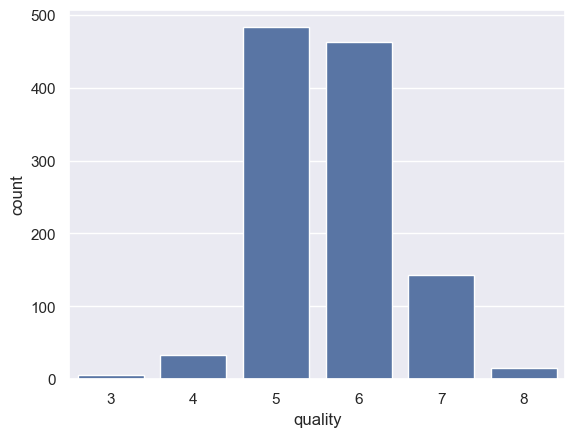

"The quality distribution has 6 values, quality scores 5 and 6 are the most frequent numbers to appear


In [11]:
plt.show(sns.countplot(x = df.quality))
print(""""The quality distribution has 6 values, quality scores 5 and 6 are the most frequent numbers to appear""")

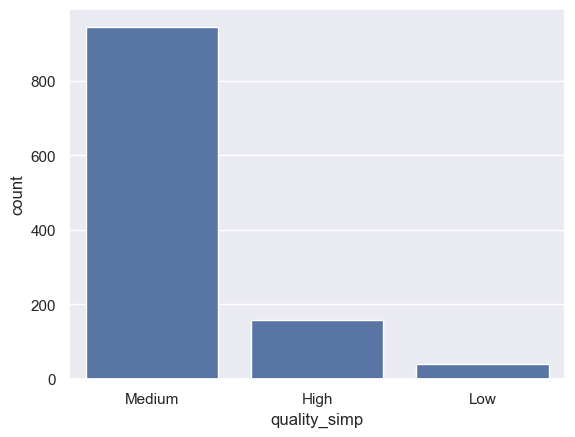

In [13]:
#To simplyfy the quality score, this notebokk will make quality score into 3 groups (Low, Medium, and High)
df['quality_simp'] = np.where(df.quality<=4, 'Low',
                        np.where(df.quality>=7, 'High', 'Medium'))
plt.show(sns.countplot(x = df.quality_simp))

In [15]:
df.quality_simp.value_counts(normalize= True)

quality_simp
Medium    0.826772
High      0.139108
Low       0.034121
Name: proportion, dtype: float64

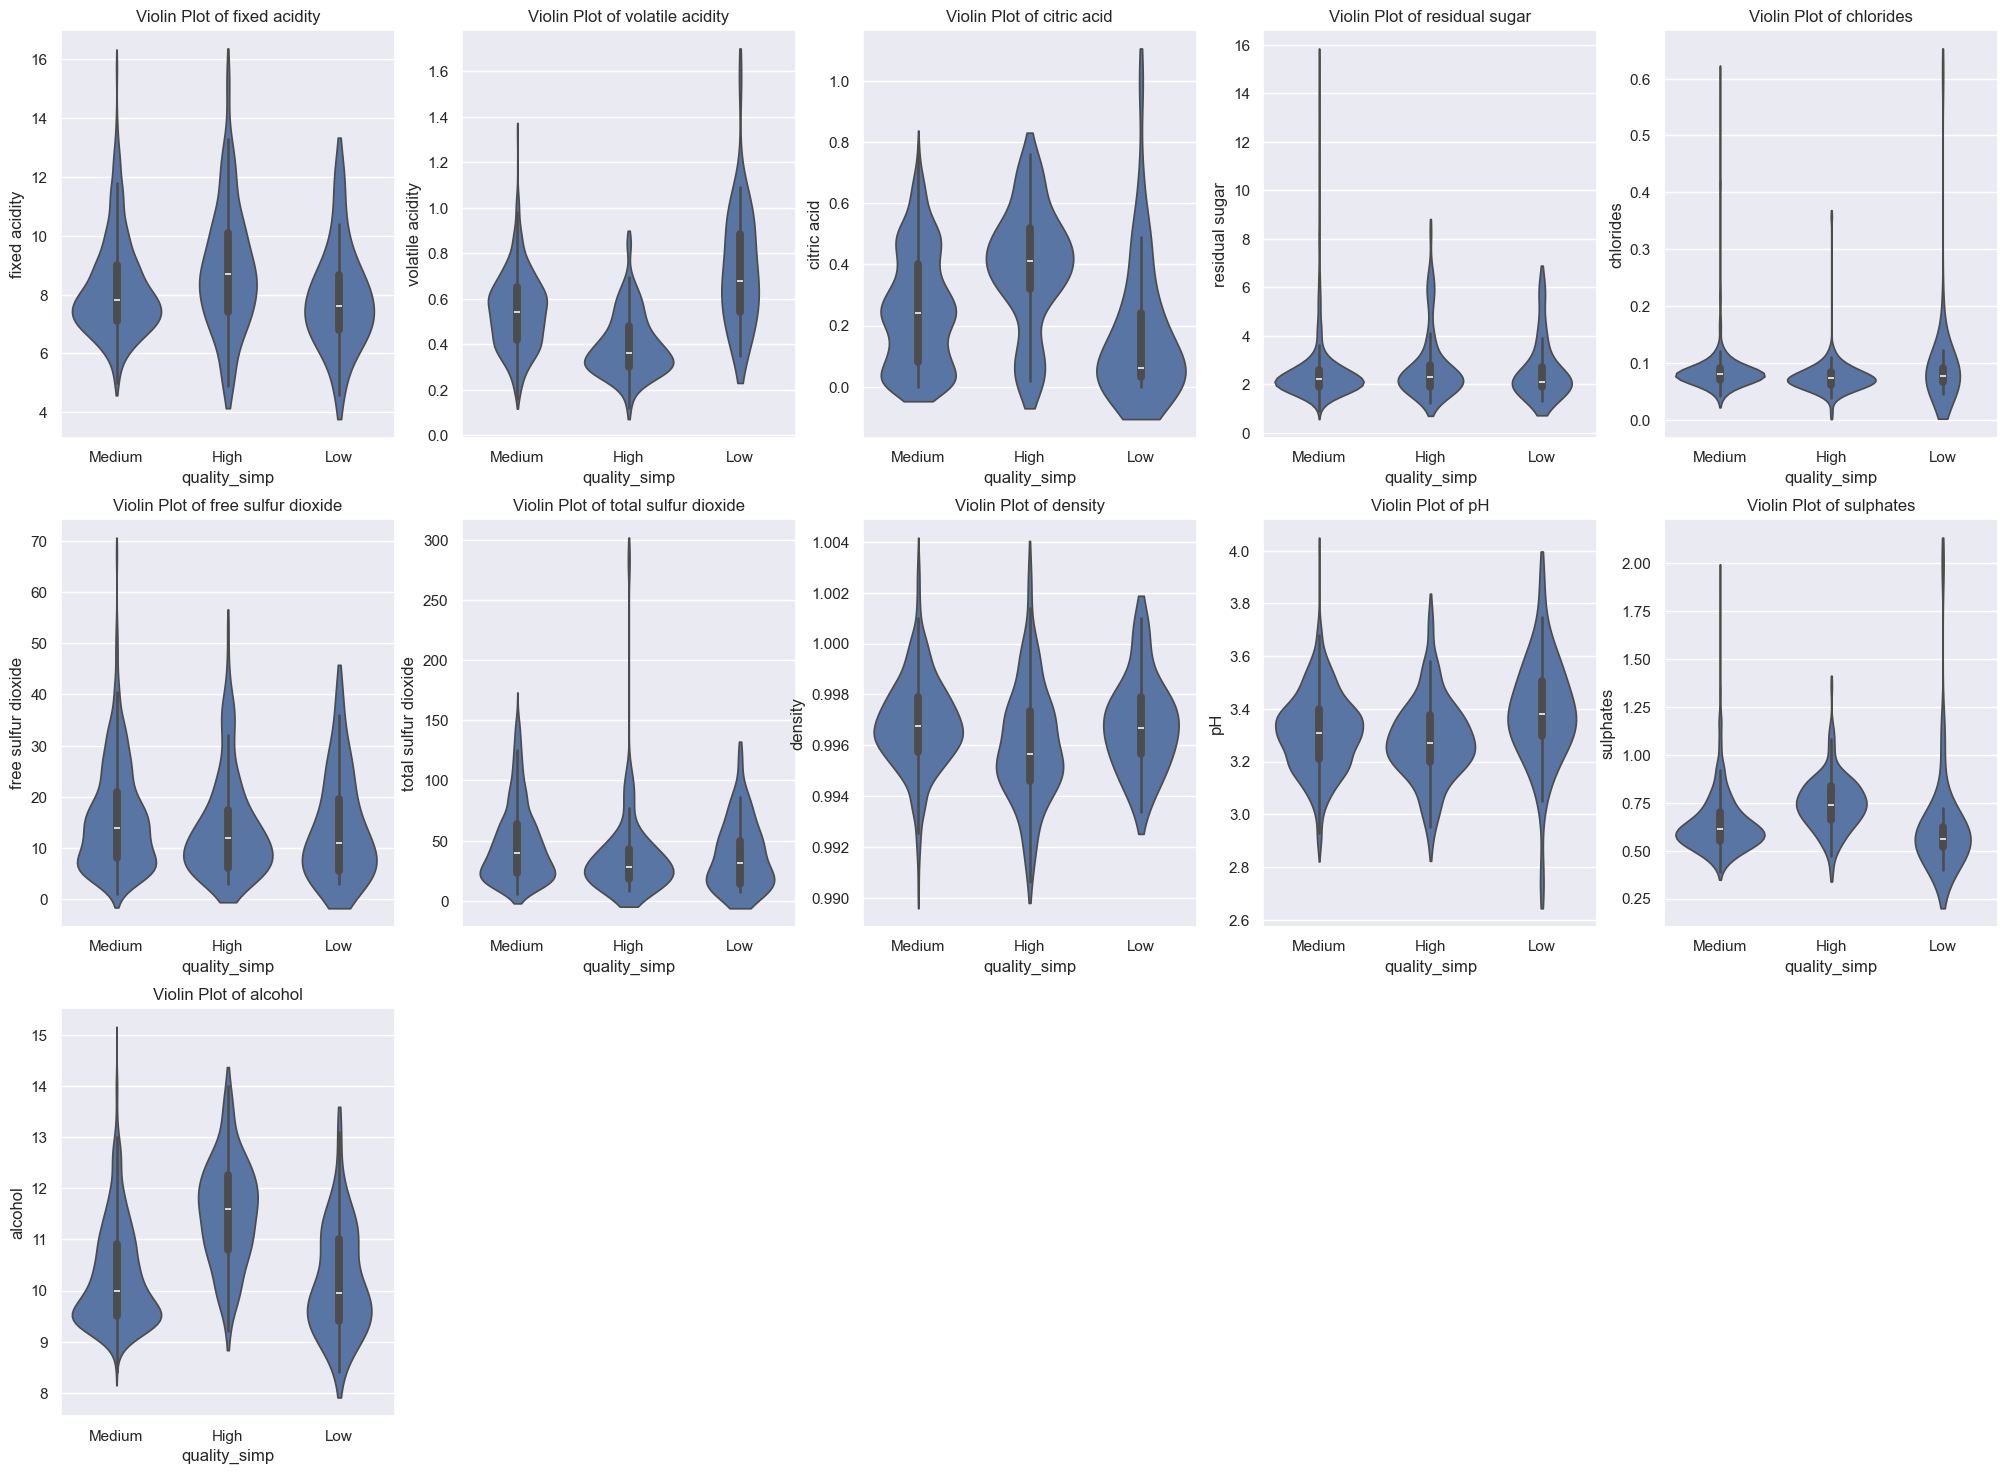

In [17]:
list_col = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol']

plt.figure(figsize = (25,18))
count = 1
for i in list_col:
    plt.subplot(3,5,count)
    plt.title(f'Violin Plot of {i}')
    sns.violinplot(data = df, x = 'quality_simp', y = i, cut= True)
    count += 1

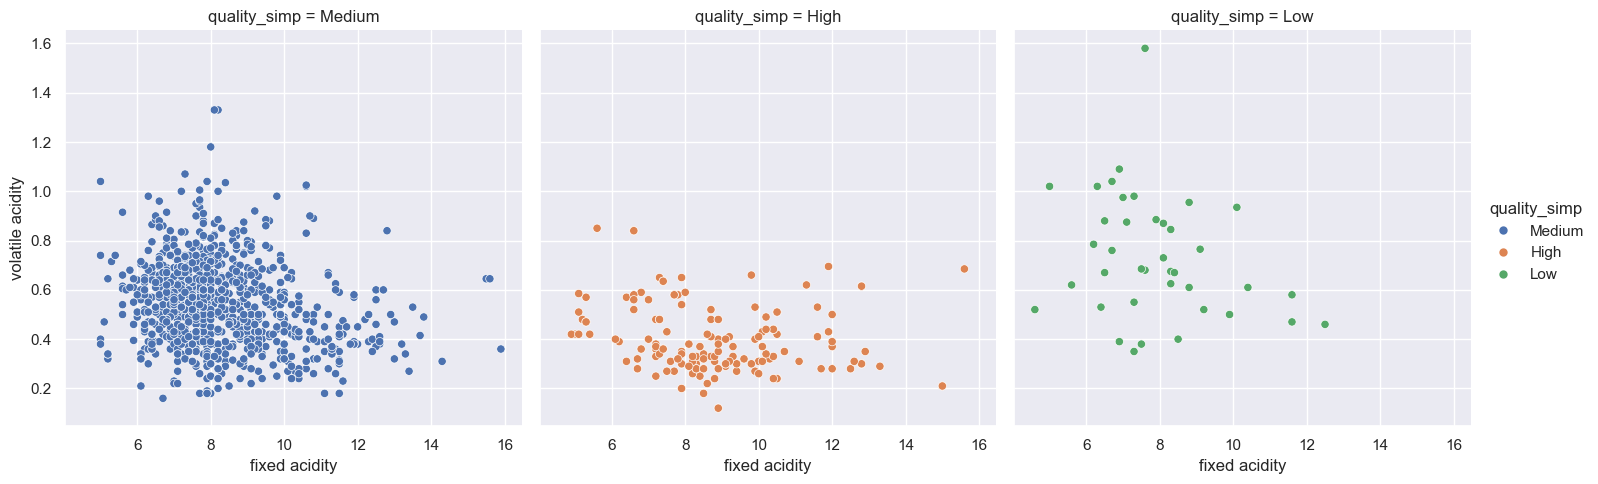

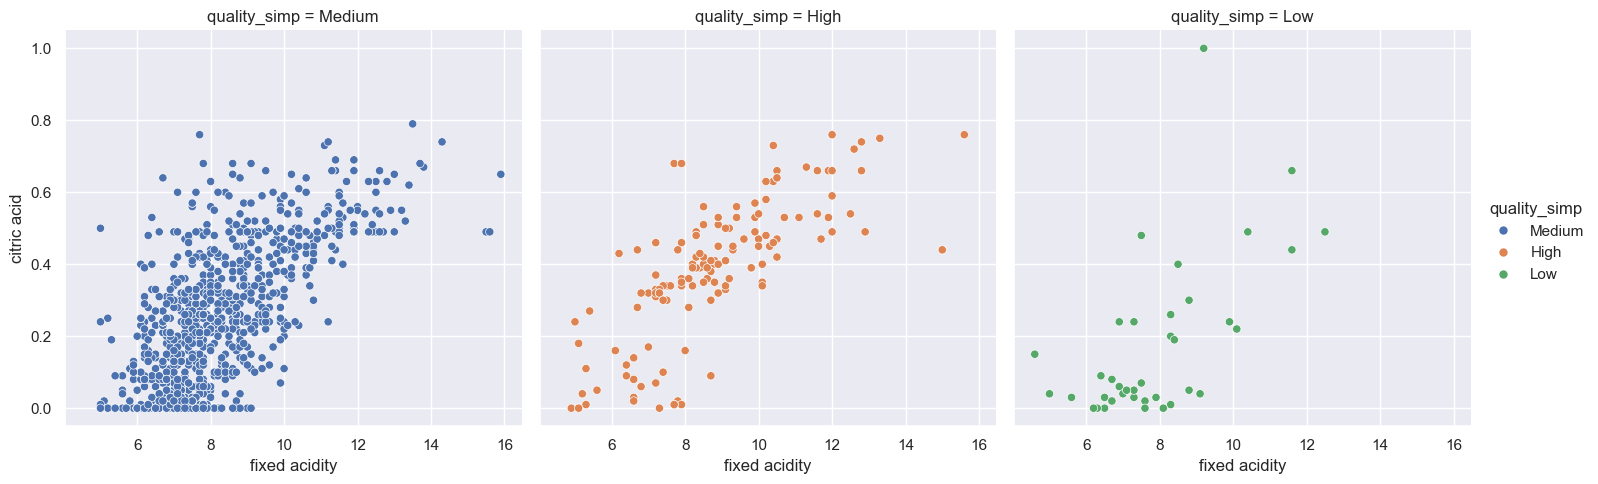

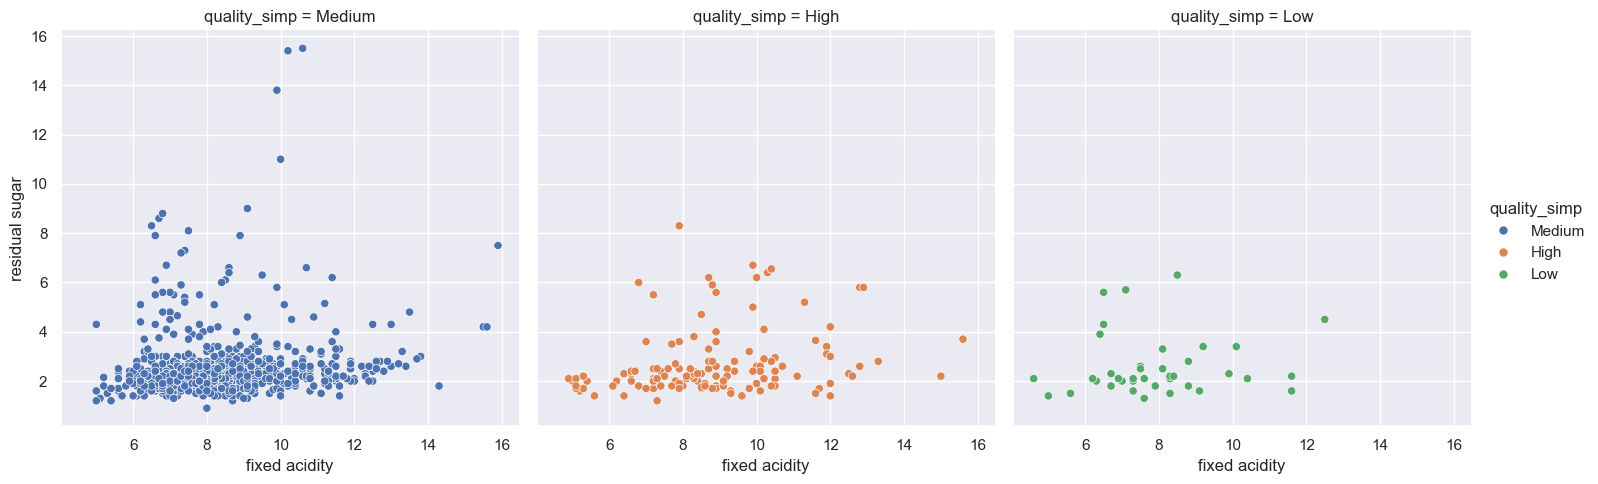

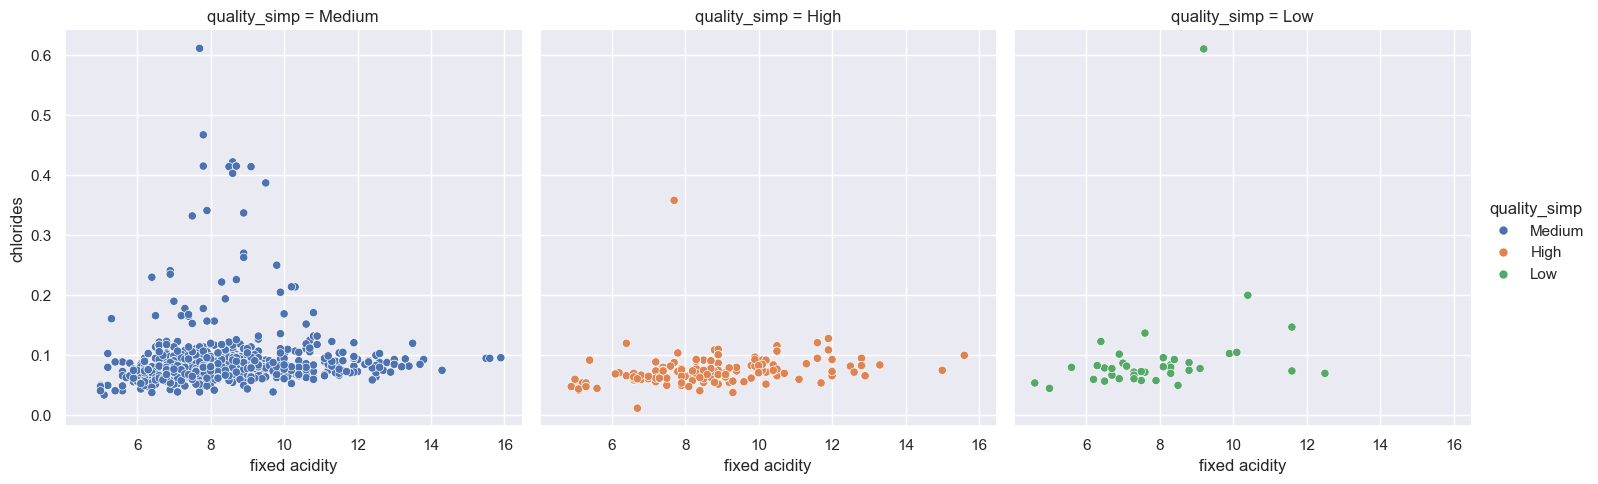

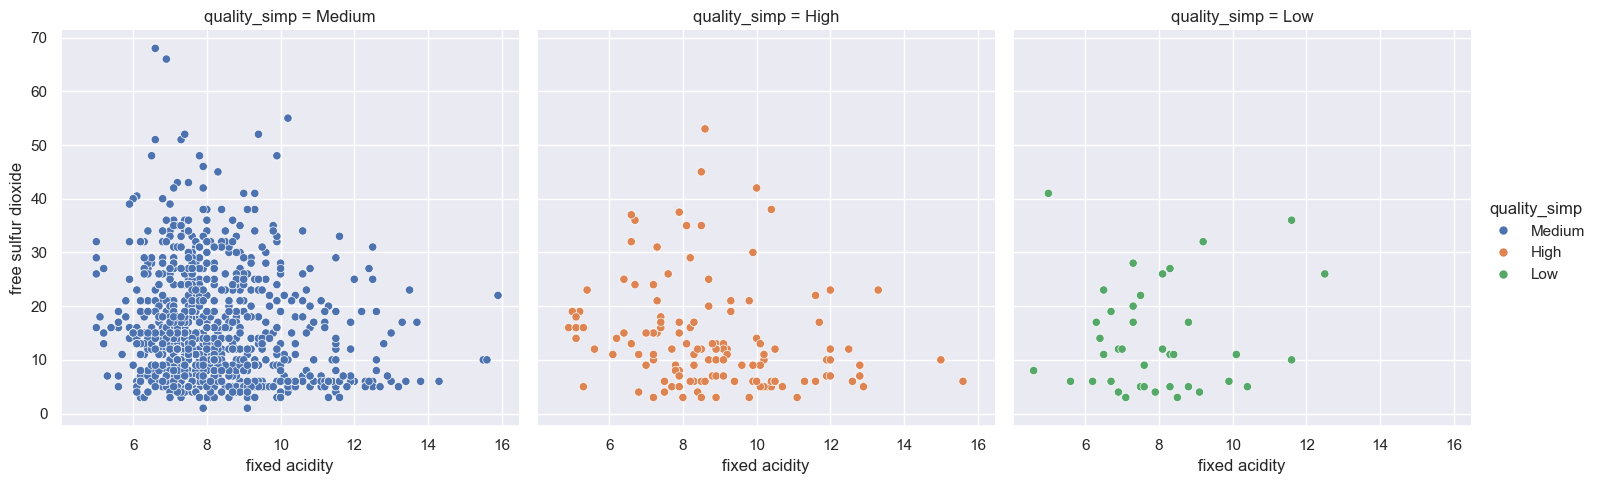

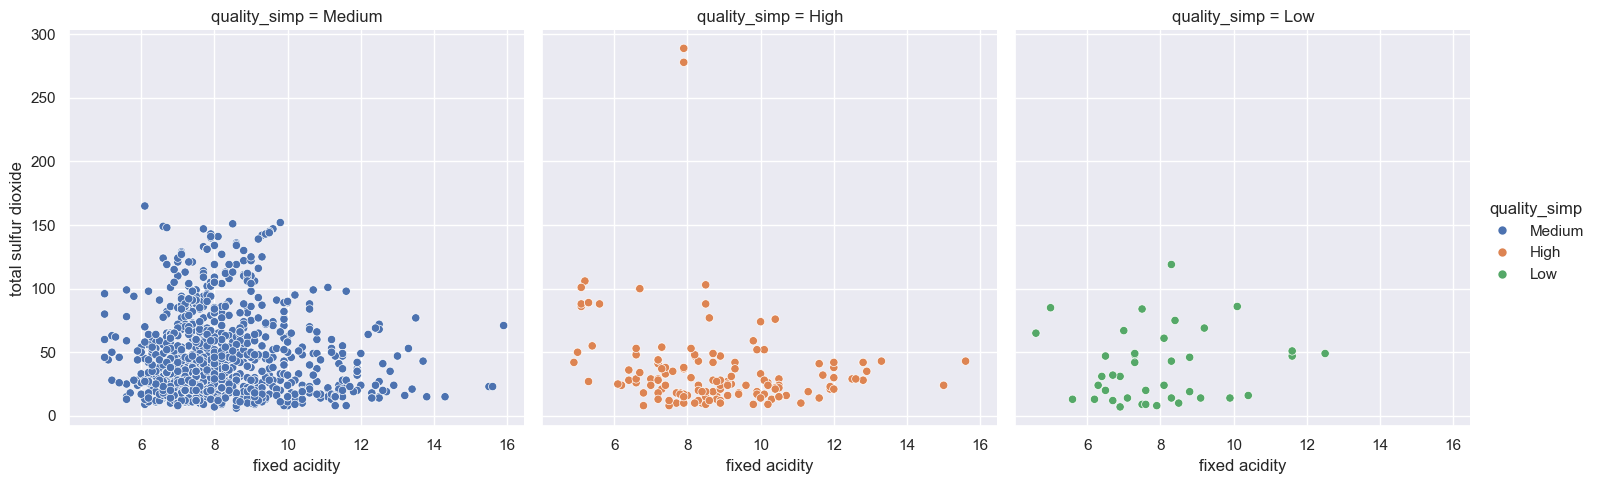

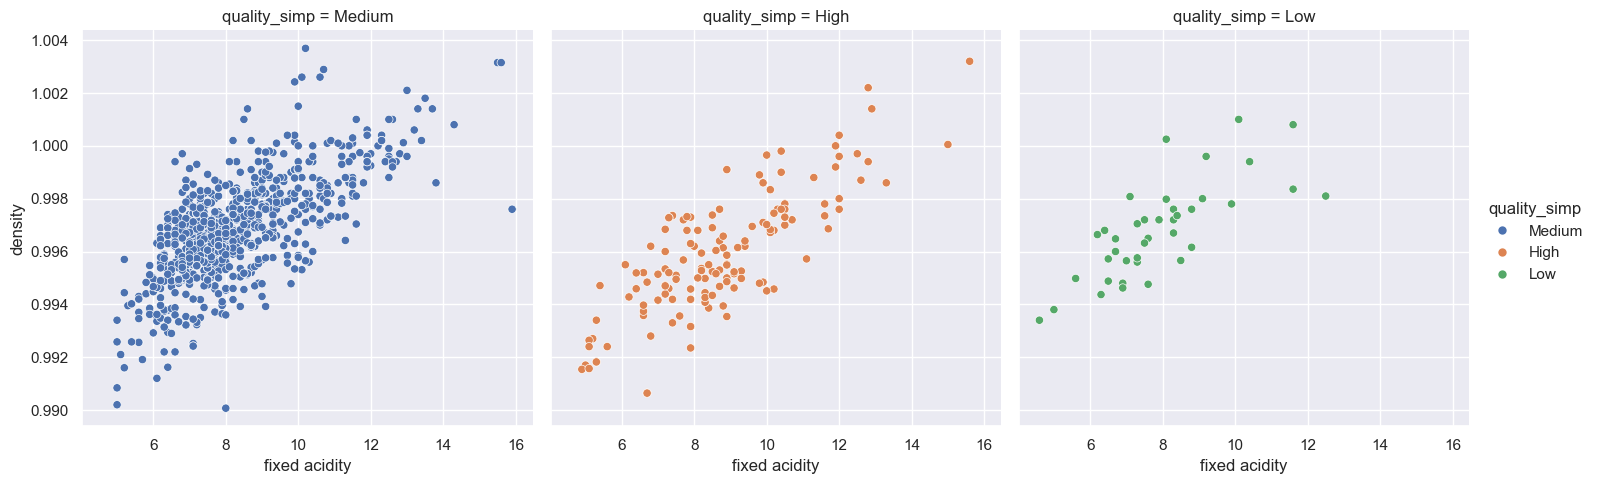

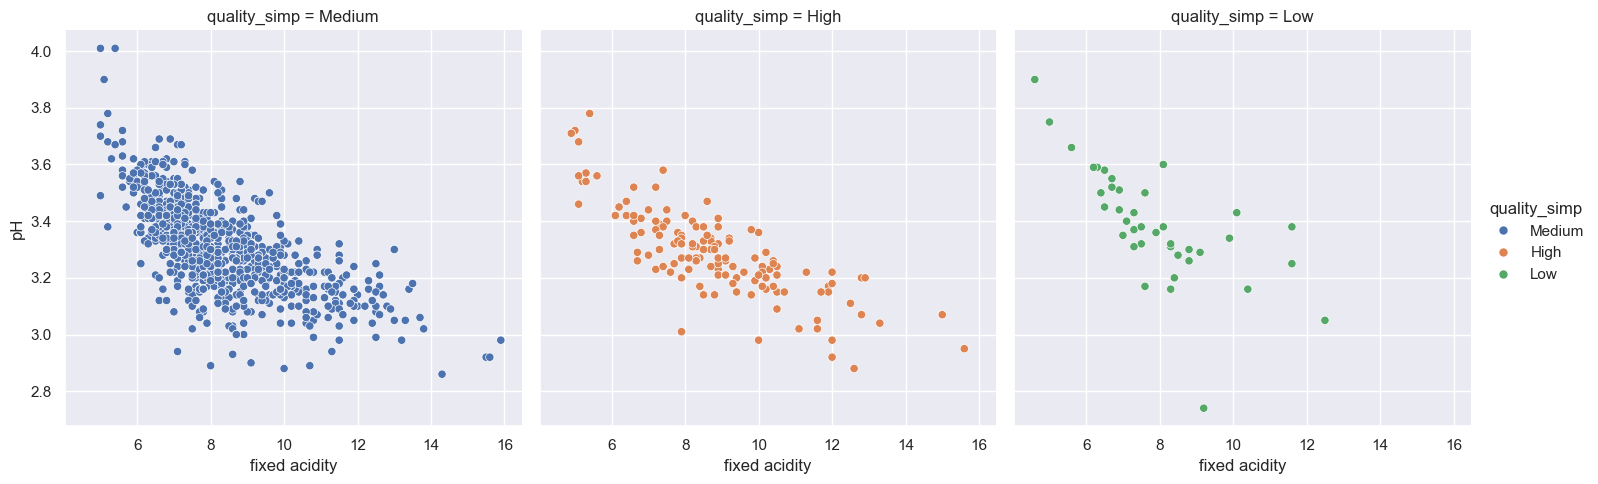

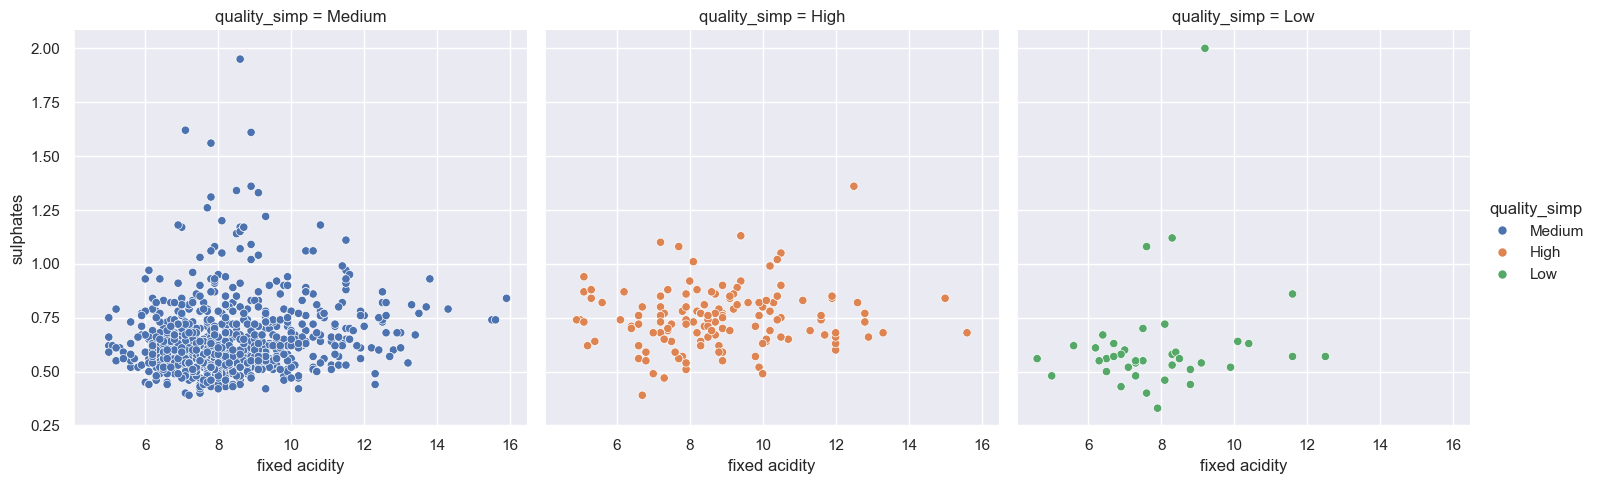

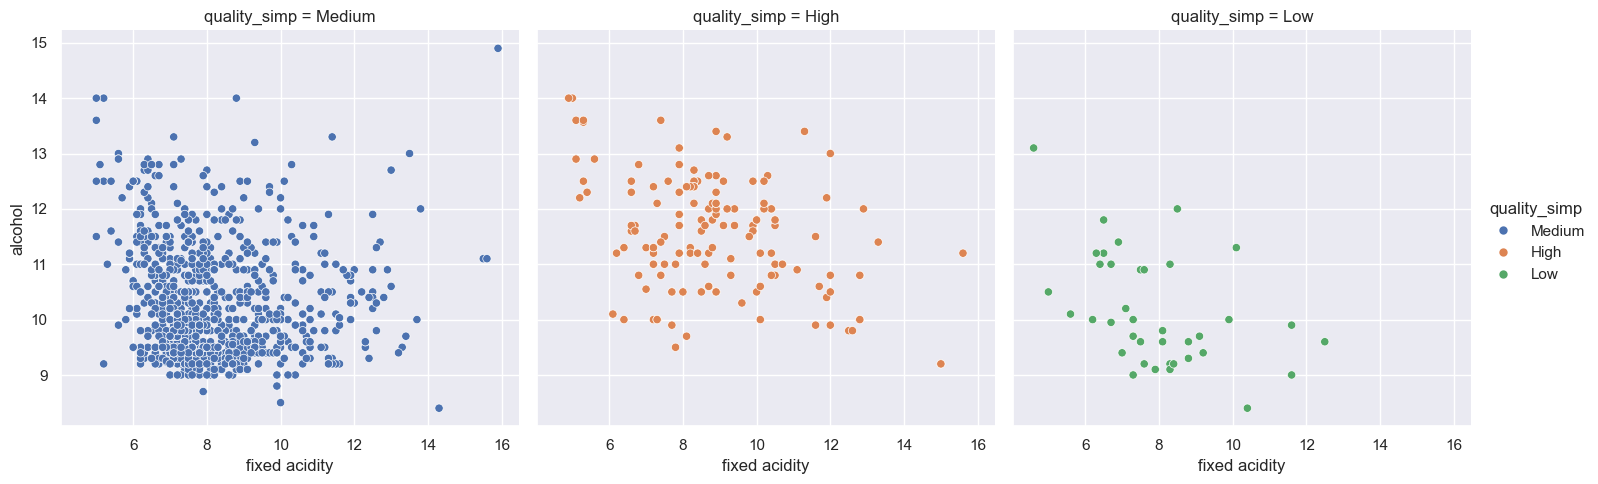

In [19]:
list_col_1 = ['volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol']

count = 1
for i in list_col_1:
    sns.relplot(data = df, x = 'fixed acidity', y = i, col= 'quality_simp', kind= 'scatter', hue= 'quality_simp')

In [21]:
X = df.drop(columns=['quality', 'quality_simp'])
y = df.quality_simp

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y, test_size= 0.25, random_state= 40)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((857, 11), (857,), (286, 11), (286,))

In [23]:
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy= 'median')),
    ('transform', PowerTransformer(method="yeo-johnson")),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, interaction_only= True))
])

pipe = Pipeline([
    ('number', num_pipe),
    ('algo', LogisticRegression(max_iter=1000, multi_class= 'ovr'))
])
parameter = {
    'algo__C': np.logspace(-3,3,7),
    'algo__fit_intercept': [True, False],
    'number__poly__degree': [2,3],
    'number__poly__interaction_only': [True, False]
}

model = RandomizedSearchCV(pipe, param_distributions= parameter, n_iter= 50, random_state= 42, verbose= 0, n_jobs= -1,cv =3, scoring= 'f1_weighted')
model.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('number',
                                              Pipeline(steps=[('impute',
                                                               SimpleImputer(strategy='median')),
                                                              ('transform',
                                                               PowerTransformer()),
                                                              ('scaler',
                                                               StandardScaler()),
                                                              ('poly',
                                                               PolynomialFeatures(interaction_only=True))])),
                                             ('algo',
                                              LogisticRegression(max_iter=1000,
                                                                 multi_class='ovr'))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'algo__fit_intercept': [True, False],
                                        'number__poly__degree': [2, 3],
                                        'number__poly__interaction_only': [True,
                                                                           False]},
                   random_state=42, scoring='f1_weighted')

In [25]:
print(f' Best Parameter : {model.best_params_}')
print(f' Best Score: {model.best_score_}, Training Score: {model.score(X_train, y_train)}, Test Score: {model.score(X_test, y_test)}')

 Best Parameter : {'number__poly__interaction_only': False, 'number__poly__degree': 3, 'algo__fit_intercept': True, 'algo__C': 0.01}
 Best Score: 0.8361151976548203, Training Score: 0.8978719110495373, Test Score: 0.8418710687408117


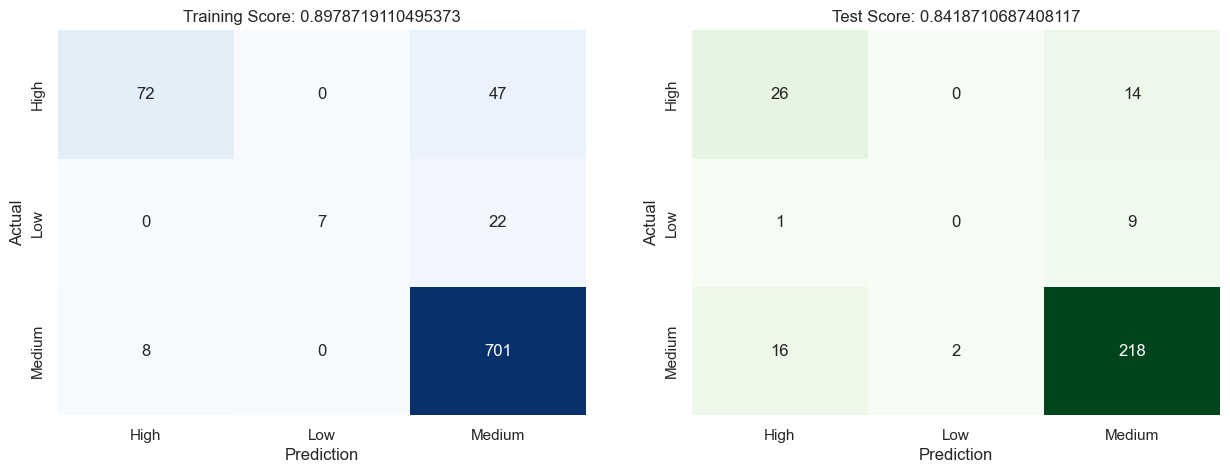

In [27]:
cm1 = pd.crosstab(y_train, model.predict(X_train))
plt.figure(figsize= (15,5))
plt.subplot(121)
plt.title(f'Training Score: {model.score(X_train, y_train)}')
sns.heatmap(cm1, annot=True, cmap='Blues',fmt='g',cbar=False )
plt.xlabel('Prediction')
plt.ylabel('Actual');

cm2 = pd.crosstab(y_test, model.predict(X_test))
plt.subplot(122)
plt.title(f'Test Score: {model.score(X_test, y_test)}')
sns.heatmap(cm2, annot=True, cmap='Greens',fmt='g',cbar=False)
plt.xlabel('Prediction')
plt.ylabel('Actual');